In [4]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
tickers = ['GOOG', 'INTC', 'ON']

In [7]:
# Commission fee based on Webull, which is known for low commission fees:
# https://www.webull.com.sg/pricing
# Regular and Extended Hours (04:00 - 20:00 EST)
# 0.025%*Total Trade Amount (Min. USD 0.50)

def commission(order_size, price):
    return max(0.5, abs(order_size) * price * 0.00025)

In [5]:
import yfinance as yf
import tqdm

start_date = "2024-03-01"
end_date = "2025-04-1" # Last day is exclusive

portfolio = {}
for asset in tqdm.tqdm(tickers):
    portfolio[asset] = {
        "data": yf.Ticker(asset).history(start=start_date, end=end_date, actions=False),
    }
    
portfolio


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


{'GOOG': {'data':                                  Open        High         Low       Close  \
  Date                                                                        
  2024-03-01 00:00:00-05:00  138.951863  139.340024  137.324576  137.429077   
  2024-03-04 00:00:00-05:00  135.896317  135.985905  132.233673  133.567352   
  2024-03-05 00:00:00-05:00  132.114232  133.388197  130.929840  133.149323   
  2024-03-06 00:00:00-05:00  133.607177  134.104820  131.327964  131.935089   
  2024-03-07 00:00:00-05:00  133.258836  135.179746  132.034638  134.602478   
  ...                               ...         ...         ...         ...   
  2025-03-25 00:00:00-04:00  171.179993  172.910004  170.550003  172.789993   
  2025-03-26 00:00:00-04:00  171.300003  171.940002  166.860992  167.139999   
  2025-03-27 00:00:00-04:00  166.710007  167.440002  163.850006  164.080002   
  2025-03-28 00:00:00-04:00  162.360001  163.809998  155.339005  156.059998   
  2025-03-31 00:00:00-04:00  154.809

## Testing with all assets and one strategy

In [8]:
import pandas_ta as ta
from backtesting import Strategy

class Strat(Strategy):
    def init(self):
        self.ma = self.I(ta.sma, self.data.Close.s, length=30)
        self.std = self.I(ta.stdev, self.data.Close.s, length=30)
        self.threshold = 1.5

    def next(self):
        price = self.data.Close[-1]
        ma = self.ma[-1]
        std = self.std[-1]
        
        if not self.position:
            if price < ma - self.threshold * std:
                self.sell()
            elif price > ma + self.threshold * std:
                self.buy()
        else:
            if self.position.size > 0 and price >= ma:
                self.position.close()
            elif self.position.size < 0 and price <= ma:
                self.position.close()

c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\JW\AppData\Local\pypoetry\Cache\virtualenvs\cryptoto-IqJLIiLB-py3.12\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [35]:
from strategies.backtest.larry_williams_price_action import LarryWilliamsPriceAction
from strategies.backtest.macd_bollinger_bands_mean_reversion import MACDBollingerBandsMeanReversion
from strategies.backtest.michael_harris_price_action import MichaelHarrisPriceAction
from strategies.backtest.rsi_divergence import RSIDivergence
from strategies.backtest.scalping import Scalping
from strategies.backtest.volume_spike_reversal import VolumeSpikeReversal
from strategies.backtest.bollinger_bands_breakout import BollingerBandsBreakout
from strategies.backtest.momentum import Momentum
from strategies.backtest.mean_reversion import MeanReversion, MeanReversionFactory

from backtesting import Backtest
import numpy as np


In [41]:
class Strat(Strategy):
    def init(self):
        self.sma = self.I(ta.sma, self.data.Close.s, timeperiod=3)
        self.mom = self.I(ta.mom, self.data.Close.s, timeperiod=2)
        self.atr = self.I(ta.atr, self.data.High.s, self.data.Low.s, self.data.Close.s, timeperiod=3)

    def next(self):
        in_position = bool(self.position)
        sma_val = self.sma[-1]
        mom_now = self.mom[-1]
        mom_prev = self.mom[-2] if len(self.mom) > 1 else np.nan
        atr_val = self.atr[-1]
        close_price = self.data.Close[-1]

        is_bullish_trend = close_price > sma_val
        bullish_cross = (mom_prev < 0) and (mom_now > 0)
        stop_loss_price = close_price - 2 * atr_val

        if is_bullish_trend and bullish_cross and not in_position:
            self.buy(sl=stop_loss_price)

        if in_position:
            if mom_now < 0:
                self.position.close()

In [42]:
data = portfolio['INTC']["data"]
data.index = data.index.values.astype("datetime64[D]")
bt = Backtest( data, Strat, cash=1000000, commission=commission, finalize_trades=True)
run_stats = bt.run().to_dict()
bt.plot()

GridPlot(id='p5814', ...)

In [43]:
df = pd.DataFrame(stats_output).drop(columns=['_equity_curve', '_trades'])
df

NameError: name 'stats_output' is not defined

In [185]:
df.to_csv("../data/processed/backtest_results.csv", index=False)

In [218]:
import pandas_ta as ta
from backtesting import Strategy


class VolumeSpikeReversal2(Strategy):
    """
    Volume Spike Reversal Strategy:
    - LONG: Volume spike + bullish candle + recent downtrend
    - SHORT: Volume spike + bearish candle + recent uptrend
    """

    def init(self):
        self.ema50 = self.I(ta.ema, self.data.Close.s, length=50)
        self.ema200 = self.I(ta.ema, self.data.Close.s, length=200)

    def next(self):
        if len(self.data.Close) < 10:
            return

        sma10_volume = self.data.Volume[-10:].mean()

        if self.data.Volume[-1] <= 2 * sma10_volume:
            return

        if self.data.Close[-1] > self.data.Open[-1] and all(
            self.ema50[-7:] < self.ema200[-7:]
        ):
            print(f'buy on day {len(self.data.Close)}')
            self.buy()

        elif self.data.Close[-1] < self.data.Open[-1] and all(
            self.ema50[-7:] > self.ema200[-7:]
        ):
            print(f'sell on day {len(self.data.Close)}')
            self.sell()
        
        else:
            print('considering')


In [219]:
asset = 'CRL'

data = portfolio[asset]["data"]
data.index = data.index.values.astype("datetime64[D]")
bt = Backtest(
    data, VolumeSpikeReversal2, cash=1000000, commission=commission, finalize_trades=True
)
run_stats = bt.run().to_dict()
stats = {'asset': asset, '_strategy': 'Unknown'}
stats.update(run_stats)

bt.plot()

considering
considering
buy on day 250


GridPlot(id='p17163', ...)

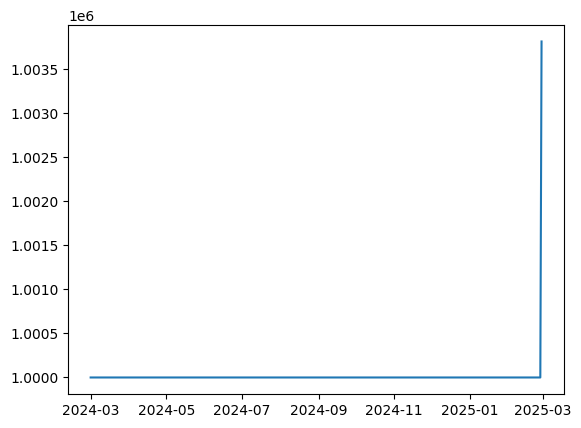

In [220]:
#plot stats['_equity_curve']

import matplotlib.pyplot as plt
plt.plot(stats['_equity_curve']['Equity'])
plt.show()


In [221]:
stats['_equity_curve'][stats['_equity_curve']['Equity'] > 1.000000e+06]


,Equity,DrawdownPct,DrawdownDuration
2025-02-28,1.003808e+06,0.0,NaN


In [222]:
stats['_trades']


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,ReturnPct,EntryTime,ExitTime,Duration,Tag
